In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 34.4 MB/s 
     |████████████████████████████████| 6.3 MB 53.0 MB/s 
     |████████████████████████████████| 16.7 MB 45.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
import os

import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras import layers
from keras import models
from keras.models import load_model
import tensorflow as tf

import ipywidgets

import matplotlib.pyplot as plt

import geopandas as gpd

In [3]:
#구글 드라이브에 연결
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
#작업 폴더 이동
os.chdir('/content/gdrive/My Drive/Colab Notebooks/urban-data-mining/08 Time Series/data/')
os.listdir()
# os.getcwd()

['월간_매매가격지수_종합.xlsx',
 '기준금리.xlsx',
 'MOCT_LINK_SEOUL.cpg',
 'MOCT_LINK_SEOUL.prj',
 'MOCT_LINK_SEOUL.shp',
 'MOCT_LINK_SEOUL.dbf',
 'MOCT_LINK_SEOUL.shx',
 'topis_final.csv']

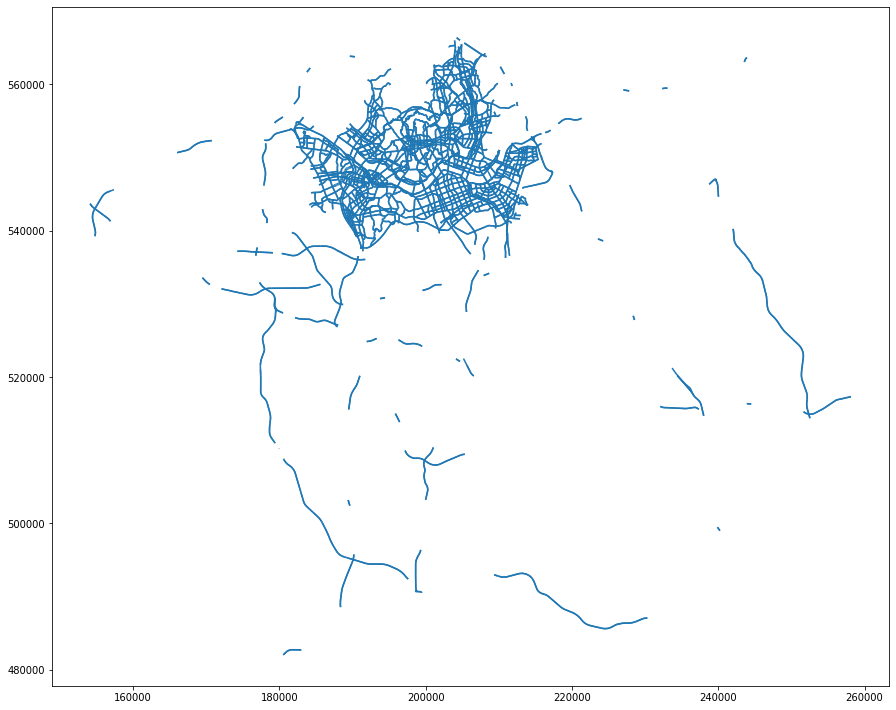

In [5]:
road = gpd.read_file('MOCT_LINK_SEOUL.shp', encoding='cp949', dtype='str')


road.plot(figsize=(15,15))
plt.show()

In [6]:
topis = pd.read_csv('topis_final.csv', dtype='float')
print(topis.shape)
print(topis.columns)

(5059, 745)
Index(['2022100101', '2022100102', '2022100103', '2022100104', '2022100105',
       '2022100106', '2022100107', '2022100108', '2022100109', '2022100110',
       ...
       '2022103116', '2022103117', '2022103118', '2022103119', '2022103120',
       '2022103121', '2022103122', '2022103123', '2022103124', 'linkid'],
      dtype='object', length=745)


In [7]:
topis['linkid'] = topis['linkid'].astype('int64').astype('str')

In [8]:
road.columns

Index(['service_id', 'LINK_ID', 'F_NODE', 'T_NODE', 'LANES', 'ROAD_RANK',
       'ROAD_TYPE', 'ROAD_NO', 'ROAD_NAME', 'ROAD_USE', 'MULTI_LINK',
       'CONNECT', 'MAX_SPD', 'REST_VEH', 'REST_W', 'REST_H', 'LENGTH',
       'REMARK', 'stand_id', 'geometry'],
      dtype='object')

In [9]:
road_topis = road.merge(topis, how='inner', left_on='service_id', right_on='linkid')

In [10]:
cols = np.array(road_topis.columns)
dates = cols[20:-1]
dates[0]

'2022100101'

In [15]:
def display_data(date='2022100101') :
  road_topis.plot(figsize=(15,15), column=date, legend=True, cmap='Reds', vmin=0, vmax=100)
  plt.title(date)
  plt.show()

ipywidgets.interact(display_data, date=dates)

interactive(children=(Dropdown(description='date', options=('2022100101', '2022100102', '2022100103', '2022100…

<function __main__.display_data(date='2022100101')>

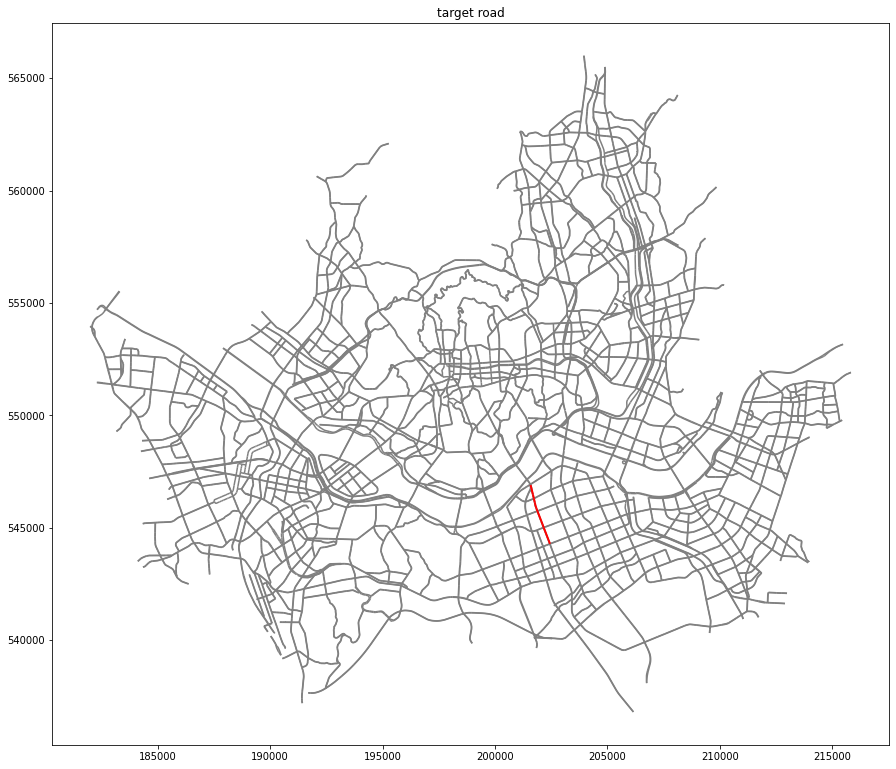

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))
road_topis.plot(ax = ax, color='gray')
road_topis[road_topis['service_id'].isin(['1220025100','1220027900','1220030700','1210030100'])].plot(ax = ax, color='red', linewidth=2)
plt.title('target road')
plt.show()

In [32]:
y_topis = topis[topis['linkid'].isin(['1220025100','1220027900','1220030700','1210030100'])]
y_topis.shape

(4, 745)

In [33]:
data = road_topis[dates].copy()
y_data = y_topis[dates].copy()

TESTING_CNT = 9
TRAINING_MONTHS = 12

ndata = data[data.columns[1:]].values
nydata = y_data[y_data.columns[1:]].values

ntraining = ndata[:, :-TESTING_CNT].T 
ntraining_y = nydata[:, :-TESTING_CNT].T 

ntesting = ndata[:, -(TRAINING_MONTHS + TESTING_CNT):].T 
ntesting_y = nydata[:, -(TRAINING_MONTHS + TESTING_CNT):].T 

if len(ntraining.shape) == 1 :
  ntraining = ntraining.reshape([ntraining.shape[0], 1])
  ntesting = ntesting.reshape([ntesting.shape[0], 1])
  

print(ntraining.shape)

(734, 5023)


In [24]:
def display_graph(data_num = 0):
  ntraining = ndata[data_num, :-TESTING_CNT].T 
  ntesting = ndata[data_num,  -(TRAINING_MONTHS + TESTING_CNT):].T  

  if len(ntraining.shape) == 1 :
    ntraining = ntraining.reshape([ntraining.shape[0], 1])
    ntesting = ntesting.reshape([ntesting.shape[0], 1])
    

  plt.plot(np.arange(ntraining.shape[0]), ntraining)
  plt.plot(np.arange(ntesting.shape[0]) + ntraining.shape[0] - TRAINING_MONTHS, ntesting, color='red')
  plt.title(data.iloc[data_num, 0])
  plt.show()


ipywidgets.interact(display_graph, data_num=(0, data.shape[0], 1))

interactive(children=(IntSlider(value=0, description='data_num', max=5023), Output()), _dom_classes=('widget-i…

<function __main__.display_graph(data_num=0)>

In [27]:
len(ntraining)

734

In [35]:
def convert_to_matrix(data, datay, step):
    x, y = [], []
    for i in range(len(data) - step):
        d = i + step
        x.append(data[i:d,:])
        y.append(datay[d, :])
    return np.array(x), np.array(y)

ntraining_x, ntraining_y = convert_to_matrix(ntraining[:,:], ntraining_y[:,:], TRAINING_MONTHS)
ntesting_x, ntesting_y = convert_to_matrix(ntesting[:,:], ntesting_y[:,:],TRAINING_MONTHS)

print(ntraining_x.shape)
print(ntraining_y.shape)

print(ntesting_x.shape)
print(ntesting_y.shape)

(722, 12, 5023)
(722, 4)
(9, 12, 5023)
(9, 4)


In [36]:
np.random.seed(1)
tf.random.set_seed(1)

inputs = layers.Input(shape=(ntraining_x.shape[1], ntraining_x.shape[2]))
net = layers.BatchNormalization()(inputs)
net = layers.LSTM(100, activation='relu')(net)
net = layers.Dense(100, activation='relu')(net)
net = layers.Dense(4)(net)
model = Model(inputs, net)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 5023)]        0         
                                                                 
 batch_normalization (BatchN  (None, 12, 5023)         20092     
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 100)               2049600   
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 2,080,196
Trainable params: 2,070,150
Non-trainable params: 10,046
______________________________________________

In [37]:
results = model.fit(ntraining_x, ntraining_y, epochs=100)

Epoch 1/100
23/23 [==============================] - 4s 34ms/step - loss: 350.2298
Epoch 2/100
23/23 [==============================] - 1s 31ms/step - loss: 73.7418
Epoch 3/100
23/23 [==============================] - 1s 32ms/step - loss: 36.9109
Epoch 4/100
23/23 [==============================] - 1s 33ms/step - loss: 18.0673
Epoch 5/100
23/23 [==============================] - 1s 33ms/step - loss: 17.9912
Epoch 6/100
23/23 [==============================] - 1s 33ms/step - loss: 16.3776
Epoch 7/100
23/23 [==============================] - 1s 34ms/step - loss: 13.2748
Epoch 8/100
23/23 [==============================] - 1s 33ms/step - loss: 9.3980
Epoch 9/100
23/23 [==============================] - 1s 33ms/step - loss: 10.8548
Epoch 10/100
23/23 [==============================] - 1s 34ms/step - loss: 8.2473
Epoch 11/100
23/23 [==============================] - 1s 32ms/step - loss: 6.7636
Epoch 12/100
23/23 [==============================] - 1s 34ms/step - loss: 6.3641
Epoch 13/100
23/

In [39]:
pred_train = model.predict(ntraining_x)
pred_test = model.predict(ntesting_x)

1/1 [==============================] - 0s 27ms/step


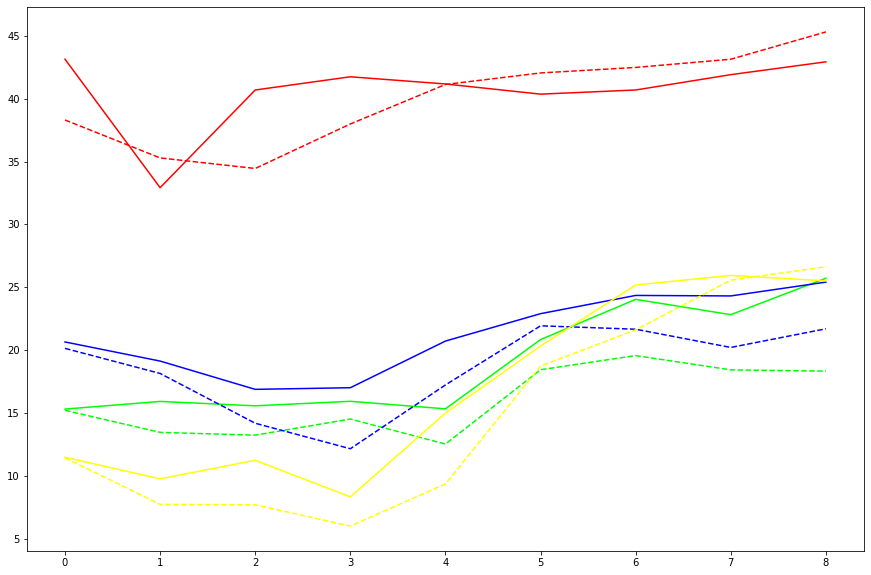

In [52]:
#실선 - 실제 값
#점선 직전 시간 네트워크 정보로 추정한 다음시간 노드 속도

plt.figure(figsize=(15,10))

pre_n = ntraining.shape[0]
post_n = TESTING_CNT

colors=['#FF0000', '#00FF00', '#0000FF', '#FFFF00']

for i in range(nydata.shape[0]):
  plt.plot(nydata[i, -TESTING_CNT:].T, color=colors[i])
  plt.plot(pred_test[ -TESTING_CNT:, i], color=colors[i], linestyle='--')

plt.show()


In [51]:
pred_test.shape

(9, 4)

In [45]:
nydata.shape

(4, 743)